In [1]:
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import matplotlib.pyplot as plt
import json
from bs4 import BeautifulSoup
import pandas as pd
from scraper_tools import go_back,go_to_next_page,wait

In [2]:
info = {'Name':['fake_entry'],
        'n_reviews':[0],
        'Reviews':[['some','fake','placeholder reviews']],
        'ReviewRatings':[[0,1,2]],
        'Price':['$15.99'],
        'Brand':['FakeBrand'],
        'img_url':["https://images-na.ssl-images-amazon.com/images/I/61o7KJvI3cL._SX300_QL70_.jpg"],
        'details':[''],
        'star_rating':["4.5 out of 5 stars"]}
reviews_df = pd.DataFrame(info)
reviews_df = reviews_df.drop(0)

In [3]:
# Functions to get the data
def loop_through_items(driver,reviews_df):
    """ Loop through items in a product search page and extract the relevant info
    """
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    results_div = soup.find('div',attrs={'class':'s-search-results'})

    # Now find the products
    results = soup.findAll('div',attrs={'class':'s-result-item'})

    # Loop through
    urls = []
    for item in results:
        item_class = item.get('class')
        # Skip the ads
        if 'AdHolder' in item_class:
            continue

        # Get the product page url and save it for later
        url = 'https://amazon.com'+item.find('a').get('href')
        urls.append(url)
    
    print('  Found {0} relevant items on this page'.format(len(urls)))
        
    # Loop through and get the info from each page
    for url in urls:
        
        # Navigate there
        driver.get(url)
        
        # Get info
        item_info = get_info(driver)
        
        # Get the reviews for this product
        review_ratings,reviews = get_reviews(driver)
        item_info['Reviews'] = reviews
        item_info['ReviewRatings'] = review_ratings
        
        reviews_df = reviews_df.append(item_info,ignore_index=True)

        # Now reset ready for the next item
        go_back(driver)
        wait()
        
        # Save to be safe
        reviews_df.to_csv('review_db.csv')
        
    return reviews_df


In [4]:
def get_info(driver):
    
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    results_div = soup.find('div',attrs={'class':'s-search-results'})

    item_info = {}
    # This block of code will help extract the Brand of the item
    for divs in soup.findAll('div', attrs={'class': 'a-box-group'}):
        try:
            item_info['Brand'] = divs['data-brand']
            break
        except:
            pass

    # This block of code will help extract the Product Title of the item
    for spans in soup.findAll('span', attrs={'id': 'productTitle'}):
        name_of_product = spans.text.strip()
        item_info['Name'] = name_of_product
        break

    # This block of code will help extract the price of the item in dollars
    for divs in soup.findAll('div'):
        try:
            price = str(divs['data-asin-price'])
            item_info['Price'] = '$' + price
            break
        except:
            pass

    # This block of code will help extract the image of the item in dollars
    for divs in soup.findAll('div', attrs={'id': 'rwImages_hidden'}):
        for img_tag in divs.findAll('img', attrs={'style': 'display:none;'
                                    }):
            item_info['img_url'] = img_tag['src']
            break

    # This block of code will help extract the average star rating of the product
    for i_tags in soup.findAll('i',
                               attrs={'data-hook': 'average-star-rating'}):
        for spans in i_tags.findAll('span', attrs={'class': 'a-icon-alt'}):
            item_info['star_rating'] = spans.text.strip()
            break

    # This block of code will help extract the number of customer reviews of the product
    for spans in soup.findAll('span', attrs={'id': 'acrCustomerReviewText'
                              }):
        if spans.text:
            review_count = spans.text.strip()
            item_info['n_reviews'] = review_count
            break

    # This block of code will help extract top specifications and details of the product
    item_info['details'] = []
    for ul_tags in soup.findAll('ul',
                                attrs={'class': 'a-unordered-list a-vertical a-spacing-none'
                                }):
        for li_tags in ul_tags.findAll('li'):
            for spans in li_tags.findAll('span',
                    attrs={'class': 'a-list-item'}, text=True,
                    recursive=False):
                item_info['details'].append(spans.text.strip())

    return item_info

def get_reviews(driver):
    """ For a given item, get all of the reviews
    """
    # Click on all reviews
    try:
        all_reviews_button = driver.find_element_by_xpath("//a[@data-hook='see-all-reviews-link-foot']")
        all_reviews_button.click()
    except:
        print('Reached end of list')
    
    wait()

    # Put a while loop here to loop over pages
    all_reviews = []
    all_ratings = []
    
    more_pages = True
    loop_ix = 0
    while more_pages:
        # Scrape this page
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        
        # Loop through reviews on the page
        reviews_on_page = soup.findAll('div',attrs={'data-hook':'review'})
        for r in reviews_on_page:
            # Get the star rating
            rating_text = r.find('i',attrs={'data-hook':"review-star-rating"}).getText()
            rating = float(rating_text[0:2])
            all_ratings.append(rating)

            # Get the review text
            review_text = r.find('span',attrs={'data-hook':"review-body"}).getText()
            all_reviews.append(review_text)
        
        #hack to test
#         if loop_ix == 2:
#             print('only doing 2 pages for now')
#             break
        
        # Go to the next page (if it's there)
        more_pages = go_to_next_page(driver)
        wait()
        
        loop_ix +=1
    # Now go back to the product page
    for ix in range(loop_ix):
        go_back(driver)
        wait()

    return all_ratings,all_reviews

In [5]:
# base_site ="https://www.amazon.com/s?k=jigsaw+puzzles+1000+pieces&i=toys-and-games&rh=n%3A166359011%2Cp_n_feature_five_browse-bin%3A3136099011&s=review-rank&dc&page=5&crid=2KIXRJG2JWYM6&qid=1568315752&rnid=2528832011&sprefix=jigsaw%2Caps%2C385&ref=sr_pg_" 
# base_site = "https://www.amazon.com/s?k=jigsaw+puzzles+1000+pieces&i=toys-and-games&bbn=166359011&rh=n%3A165793011%2Cn%3A166359011%2Cp_n_feature_five_browse-bin%3A3136099011%2Cp_89%3ACobble+Hill%7CD-Toys%7CEuroGraphics%7CGibsons%7CHeye%7CRavensburger%7CSchmidt+Spiele%7CVermont+Christmas+Company%7CWhite+Mountain%7CWhite+Mountain+Puzzles&dc&fst=as%3Aoff&qid=1568329514&rnid=2528832011&ref=sr_pg_1"
base_site = "https://www.amazon.com/s?k=jigsaw+puzzles+1000+pieces&i=toys-and-games&bbn=166359011&rh=n%3A165793011%2Cn%3A166359011%2Cp_n_feature_five_browse-bin%3A3136099011%2Cp_72%3A1248964011&dc&fst=as%3Aoff&qid=1568335199&refresh=2&rnid=1248961011&ref=sr_nr_p_72_2"
driver = webdriver.Chrome()
driver.get(base_site)
wait(amount=5)

# Main loop through search pages:
for ix in range(2):

    # Click on an item and add that info
    reviews_df = loop_through_items(driver,reviews_df)

    # Wait just to be safe
    wait(amount=np.random.uniform(low=2,high=5))
    
    go_to_next_page(driver)
print('Done!')

  Found 24 relevant items on this page
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
Reached end of list 
  Found 0 relevant items on this page
Done!


In [6]:
# try:
#     all_reviews_button = driver.find_element_by_xpath("//a[@data-hook='see-all-reviews-link-foot']")
#     all_reviews_button.click()
# except:
#     print('Reached end of list')

# next_button = driver.find_elements_by_class_name('a-last')
# help(next_button[0])

# go_to_next_page(driver)
# go_back(driver)
# Scrape this page
print('Done!')

Done!


In [43]:
# print(reviews_df)
reviews_df.to_csv('review_db.csv')

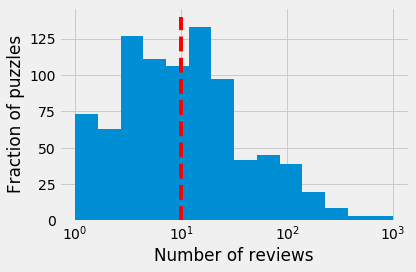

In [257]:
import matplotlib
matplotlib.style.use('fivethirtyeight')
ratings = np.array(ratings)
# print('Min # ratings: ',np.min(ratings))
# np.savetxt('all_ratings.txt',ratings)
bins = np.logspace(0,3,num=15)
plt.clf()
plt.hist(ratings,bins=bins)
plt.xscale('log')
plt.xlabel('Number of reviews')
plt.ylabel('Fraction of puzzles')
plt.plot([10,10],plt.ylim(),'r--')
plt.tight_layout()
plt.savefig('n_review_histogram2.png')

Found 410 with more than 10 reviews
Out of 871 total
23400


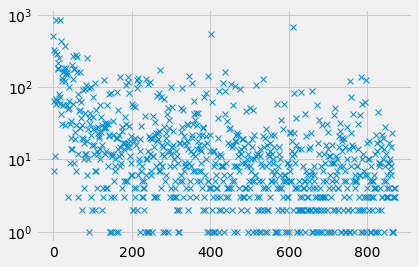

In [258]:
plt.clf()
plt.plot(ratings,'x')
plt.yscale('log')

x = 10
n_above_x = np.sum(ratings>x)
print('Found {0} with more than {1} reviews'.format(n_above_x,x))
print('Out of {0} total'.format(len(ratings)))
print(np.sum(ratings[ratings>x]))

In [142]:
with open('page.html','w') as myf:
    myf.write(driver.page_source)

<html lang="en-us" class=" a-js a-audio a-video a-canvas a-svg a-drag-drop a-geolocation a-history a-webworker a-autofocus a-input-placeholder a-textarea-placeholder a-local-storage a-gradients a-hires a-transform3d a-touch-scrolling a-text-shadow a-text-stroke a-box-shadow a-border-radius a-border-image a-opacity a-transform a-transition a-ember" data-19ax5a9jf="dingo" data-aui-build-date="3.19.6-2019-09-04"><!-- sp:feature:head-start --><head><script async="" src="https://images-na.ssl-images-amazon.com/images/G/01/AUIClients/ClientSideMetricsAUIJavascript@jserrorsForester.10f2559e93ec589d92509318a7e2acbac74c343a._V2_.js" crossorigin="anonymous"></script><script>var aPageStart = (new Date()).getTime();</script><meta charset="utf-8">
<script type="text/javascript">var ue_t0=ue_t0||+new Date();</script><!-- sp:feature:cs-optimization -->
<script type="text/javascript">
window.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;
if (window.ue_ihb === 1) {

var ue_csm = window,
    ue_hob